# Market Mix Model

- <b>Objective </b> : Develop a market mix model to observe the actual impact of different marketing variables over the last year. Also provide recommendation for optimal budget allocation for different marketing levers.

In [237]:
# Import libraries
import pandas as pd
import numpy as np

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

In [238]:
import warnings
warnings.filterwarnings('ignore')

In [239]:
# Set options
pd.set_option('display.max_rows',40000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [240]:
consumer_df = pd.read_csv('ConsumerElectronics.csv')

In [241]:
consumer_df.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400,1,\N,\N,COD,5,-1.01299130778588E+018,-7.79175582905735E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900,1,\N,\N,COD,7,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990,1,\N,\N,COD,10,-1.0404429420466E+018,-7.47768776228657E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690,1,\N,\N,Prepaid,4,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618,1,\N,\N,Prepaid,6,2.8945572083453E+018,5.34735360997242E+017,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


### Understanding and Data Cleaning

In [242]:
consumer_df.shape

(1648824, 20)

In [243]:
consumer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
fsn_id                             1648824 non-null object
order_date                         1648824 non-null object
Year                               1648824 non-null int64
Month                              1648824 non-null int64
order_id                           1648824 non-null float64
order_item_id                      1648824 non-null float64
gmv                                1648824 non-null object
units                              1648824 non-null int64
deliverybdays                      1648824 non-null object
deliverycdays                      1648824 non-null object
s1_fact.order_payment_type         1648824 non-null object
sla                                1648824 non-null int64
cust_id                            1648824 non-null object
pincode                            1648824 non-null object
product_analytic_super_category    1648824 non-null object
prod

In [244]:
# convert order_date to date time format
consumer_df['order_date'] = pd.to_datetime(consumer_df['order_date'], format="%Y-%m-%d %H:%M:%S")

In [245]:
consumer_df['order_date'].dtype

dtype('<M8[ns]')

In [246]:
consumer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
fsn_id                             1648824 non-null object
order_date                         1648824 non-null datetime64[ns]
Year                               1648824 non-null int64
Month                              1648824 non-null int64
order_id                           1648824 non-null float64
order_item_id                      1648824 non-null float64
gmv                                1648824 non-null object
units                              1648824 non-null int64
deliverybdays                      1648824 non-null object
deliverycdays                      1648824 non-null object
s1_fact.order_payment_type         1648824 non-null object
sla                                1648824 non-null int64
cust_id                            1648824 non-null object
pincode                            1648824 non-null object
product_analytic_super_category    1648824 non-null obj

In [247]:
# Sort values by order date
consumer_df = consumer_df.sort_values(by = 'order_date')

In [248]:
consumer_df.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
1376093,ACCDVZ83VBHCWFFA,2015-05-19 13:42:09,2015,5,146499482.0,188485029.0,3149,1,\N,\N,COD,6,-6.14850311678963E+018,-3.21775258155408E+018,CE,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,6990,4
1436634,VGLE4VR7XSQKYFG7,2015-06-11 18:21:50,2015,6,155827856.0,198823138.0,275,1,\N,\N,COD,8,1.58583155812679E+018,-3.70342091330123E+017,CE,EntertainmentSmall,TVVideoSmall,VideoGlasses,600,2
1398258,ACCE6VGHYKYFX4WB,2015-06-24 10:20:16,2015,6,161931009.0,205976637.0,188,1,\N,\N,COD,8,-4.88207864623487E+018,2.04427084691886E+018,CE,EntertainmentSmall,Speaker,LaptopSpeaker,310,-1
1385002,ACCE2V5DUDZVGFRK,2015-06-25 16:28:12,2015,6,163016530.0,207267972.0,250,1,\N,\N,COD,7,-4.27261305168723E+018,6.14822284391839E+018,CE,EntertainmentSmall,Speaker,LaptopSpeaker,400,4
1358453,ACCDFZEJ6ZGSWRMK,2015-06-26 17:02:01,2015,6,163400507.0,207701702.0,1119,1,\N,\N,COD,28,-7.47222175673193E+018,-9.779010321304E+017,CE,EntertainmentSmall,Speaker,LaptopSpeaker,2500,3


In [249]:
# Converting the order_id and order_item_id to proper format -> Object
consumer_df['order_id'] = consumer_df['order_id'].map(lambda x : '{:.0f}'.format(x))
consumer_df['order_item_id'] = consumer_df['order_item_id'].map(lambda x : '{:.0f}'.format(x))

In [250]:
consumer_df.dtypes

fsn_id                                     object
order_date                         datetime64[ns]
Year                                        int64
Month                                       int64
order_id                                   object
order_item_id                              object
gmv                                        object
units                                       int64
deliverybdays                              object
deliverycdays                              object
s1_fact.order_payment_type                 object
sla                                         int64
cust_id                                    object
pincode                                    object
product_analytic_super_category            object
product_analytic_category                  object
product_analytic_sub_category              object
product_analytic_vertical                  object
product_mrp                                 int64
product_procurement_sla                     int64


In [251]:
consumer_df.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
1376093,ACCDVZ83VBHCWFFA,2015-05-19 13:42:09,2015,5,146499482,188485029,3149,1,\N,\N,COD,6,-6.14850311678963E+018,-3.21775258155408E+018,CE,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,6990,4
1436634,VGLE4VR7XSQKYFG7,2015-06-11 18:21:50,2015,6,155827856,198823138,275,1,\N,\N,COD,8,1.58583155812679E+018,-3.70342091330123E+017,CE,EntertainmentSmall,TVVideoSmall,VideoGlasses,600,2
1398258,ACCE6VGHYKYFX4WB,2015-06-24 10:20:16,2015,6,161931009,205976637,188,1,\N,\N,COD,8,-4.88207864623487E+018,2.04427084691886E+018,CE,EntertainmentSmall,Speaker,LaptopSpeaker,310,-1
1385002,ACCE2V5DUDZVGFRK,2015-06-25 16:28:12,2015,6,163016530,207267972,250,1,\N,\N,COD,7,-4.27261305168723E+018,6.14822284391839E+018,CE,EntertainmentSmall,Speaker,LaptopSpeaker,400,4
1358453,ACCDFZEJ6ZGSWRMK,2015-06-26 17:02:01,2015,6,163400507,207701702,1119,1,\N,\N,COD,28,-7.47222175673193E+018,-9.779010321304E+017,CE,EntertainmentSmall,Speaker,LaptopSpeaker,2500,3


In [252]:
# Creating new column for Week Number
consumer_df['week_num'] = consumer_df['order_date'].dt.week

In [253]:
consumer_df.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,week_num
1376093,ACCDVZ83VBHCWFFA,2015-05-19 13:42:09,2015,5,146499482,188485029,3149,1,\N,\N,COD,6,-6.14850311678963E+018,-3.21775258155408E+018,CE,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,6990,4,21
1436634,VGLE4VR7XSQKYFG7,2015-06-11 18:21:50,2015,6,155827856,198823138,275,1,\N,\N,COD,8,1.58583155812679E+018,-3.70342091330123E+017,CE,EntertainmentSmall,TVVideoSmall,VideoGlasses,600,2,24
1398258,ACCE6VGHYKYFX4WB,2015-06-24 10:20:16,2015,6,161931009,205976637,188,1,\N,\N,COD,8,-4.88207864623487E+018,2.04427084691886E+018,CE,EntertainmentSmall,Speaker,LaptopSpeaker,310,-1,26
1385002,ACCE2V5DUDZVGFRK,2015-06-25 16:28:12,2015,6,163016530,207267972,250,1,\N,\N,COD,7,-4.27261305168723E+018,6.14822284391839E+018,CE,EntertainmentSmall,Speaker,LaptopSpeaker,400,4,26
1358453,ACCDFZEJ6ZGSWRMK,2015-06-26 17:02:01,2015,6,163400507,207701702,1119,1,\N,\N,COD,28,-7.47222175673193E+018,-9.779010321304E+017,CE,EntertainmentSmall,Speaker,LaptopSpeaker,2500,3,26


In [254]:
# Function to map week num in continuation with 2015

def continousweek(week_num,year):
    if(year==2016) and (week_num <= 26):
        return week_num+53
    else:
        return week_num

In [255]:
# map week function to week_num
consumer_df['week_num']= consumer_df.apply(lambda x : continousweek(x['week_num'],x['Year']), axis=1)

In [256]:
consumer_df.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,week_num
1376093,ACCDVZ83VBHCWFFA,2015-05-19 13:42:09,2015,5,146499482,188485029,3149,1,\N,\N,COD,6,-6.14850311678963E+018,-3.21775258155408E+018,CE,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,6990,4,21
1436634,VGLE4VR7XSQKYFG7,2015-06-11 18:21:50,2015,6,155827856,198823138,275,1,\N,\N,COD,8,1.58583155812679E+018,-3.70342091330123E+017,CE,EntertainmentSmall,TVVideoSmall,VideoGlasses,600,2,24
1398258,ACCE6VGHYKYFX4WB,2015-06-24 10:20:16,2015,6,161931009,205976637,188,1,\N,\N,COD,8,-4.88207864623487E+018,2.04427084691886E+018,CE,EntertainmentSmall,Speaker,LaptopSpeaker,310,-1,26
1385002,ACCE2V5DUDZVGFRK,2015-06-25 16:28:12,2015,6,163016530,207267972,250,1,\N,\N,COD,7,-4.27261305168723E+018,6.14822284391839E+018,CE,EntertainmentSmall,Speaker,LaptopSpeaker,400,4,26
1358453,ACCDFZEJ6ZGSWRMK,2015-06-26 17:02:01,2015,6,163400507,207701702,1119,1,\N,\N,COD,28,-7.47222175673193E+018,-9.779010321304E+017,CE,EntertainmentSmall,Speaker,LaptopSpeaker,2500,3,26


In [257]:
# Check if week numbers are converted correctly
# consumer_df.loc[consumer_df['order_date'].dt.month.isin([11,12,1,2])][['Year','week_num']].head(30)

#### Fix Data types for columns

deliverybdays = number of days to deliver product from warehouse to shipping <br>
deliverycdays = number of days to deliver product to the customer.

- <b>Fixing deliverybdays, deliverycdays data type as int</b>

In [258]:
consumer_df['deliverybdays']= pd.to_numeric(consumer_df['deliverybdays'], errors='coerce')
consumer_df['deliverybdays'].fillna(value=0, inplace=True)

consumer_df['deliverycdays']= pd.to_numeric(consumer_df['deliverycdays'], errors='coerce')
consumer_df['deliverycdays'].fillna(value=0, inplace=True)

Handling negative values for deliverybdays deliverycdays as it can't be negative

In [259]:
print(consumer_df.loc[consumer_df['deliverybdays'] < 0].shape[0])
print(round(100*(consumer_df.loc[consumer_df['deliverybdays'] < 0].shape[0]/consumer_df.shape[0]),4))

38
0.0023


In [260]:
print(consumer_df.loc[consumer_df['deliverycdays'] < 0].shape[0])
print(round(100*(consumer_df.loc[consumer_df['deliverycdays']< 0].shape[0]/consumer_df.shape[0]),4))

39
0.0024


- There are 38 (0.002%) records with negative value for deliverybdays
- There are 39 (0.002%) records with negative value for deliverycdays

As it is not possible for dispatch and deliver to customer days as -negative hence dropping the negative values

In [261]:
consumer_df = consumer_df.loc[(consumer_df['deliverybdays'] >= 0) & (consumer_df['deliverycdays'] >= 0)]
consumer_df.reset_index(drop = True, inplace = True)

In [262]:
consumer_df.shape

(1648785, 21)

<b> Fix GMV (Gross merchandise value) column

check if GMV values is higher than the <b>*product_mrp * units*</b>

In [263]:
consumer_df['gmv'] = pd.to_numeric(consumer_df['gmv'], errors='coerce')

In [264]:
print(consumer_df.loc[(consumer_df['product_mrp']*consumer_df['units']) < consumer_df['gmv']].shape[0])

# Percentage of such values
print(round(100*(consumer_df.loc[(consumer_df['product_mrp']*consumer_df['units']) < consumer_df['gmv']].shape[0]
                 /consumer_df.shape[0]),2))

38568
2.34


<b>GMV = product_mrp * units </b>

so hence if mrp is missing it can be imputed with: mrp = gmv/units

In [265]:
# update product_mrp based on GMV/units
consumer_df.product_mrp = np.where(consumer_df['product_mrp'] < consumer_df['gmv']/consumer_df['units'], \
                                   consumer_df['gmv']/consumer_df['units'], consumer_df['product_mrp'])
consumer_df.shape

(1648785, 21)

In [266]:
# Check instance of gmv greater than product_mrp* units again
print(consumer_df.loc[(consumer_df['product_mrp']*consumer_df['units']) < consumer_df['gmv']].shape[0])

# Percentage of such values
print(round(100*(consumer_df.loc[(consumer_df['product_mrp']*consumer_df['units']) < consumer_df['gmv']].shape[0]
                 /consumer_df.shape[0]),2))

0
0.0


Hence after correcting the MRP there are no instance of GMV being greater than product_mrp * units

- Check GMV columns if it got negative values

In [267]:
print(consumer_df.loc[consumer_df['gmv']<0].shape[0])
# percentages of null
print(round(100*(consumer_df.loc[consumer_df['gmv']<0].shape[0]/consumer_df.shape[0]),2))

0
0.0


#### Check below columns for 0 or -ve values

1. product_mrp
2. units
3. product_procurement_sla

In [268]:
print(consumer_df.loc[consumer_df['product_mrp'] < 0].shape[0]) # Price can be zero hence only checking for -ve values
print(round(100*(consumer_df.loc[consumer_df['product_mrp']<0].shape[0]/consumer_df.shape[0]),2))

0
0.0


In [269]:
print(consumer_df.loc[consumer_df['units'] <= 0].shape[0])
print(round(100*(consumer_df.loc[consumer_df['units']<0].shape[0]/consumer_df.shape[0]),2))

0
0.0


In [270]:
print(consumer_df.loc[consumer_df['product_procurement_sla'] < 0].shape[0])
print(round(100*(consumer_df.loc[consumer_df['product_procurement_sla']<0].shape[0]/consumer_df.shape[0]),2))

75986
4.61


- There are 75986 (4.61%) values where procurement days are negative
- Procurement days can't be negative hence to fix it, it should be removed

In [271]:
consumer_df = consumer_df.loc[consumer_df['product_procurement_sla']>= 0]
consumer_df.reset_index(drop=True, inplace= True)

In [272]:
consumer_df.shape

(1572799, 21)

Checking for high product_procurement_sla values

In [273]:
consumer_df[['product_procurement_sla']].describe().T

,count,mean,std,min,25%,50%,75%,max
product_procurement_sla,1572799.0,5.712887,54.724168,0.0,2.0,2.0,3.0,1000.0


In [274]:
consumer_df['product_procurement_sla'].value_counts()

2       528406
1       308504
3       303349
5       222097
4       120190
0        42459
6        18559
7        11746
15        6184
14        5281
1000      4745
13         526
8          523
9           97
10          73
12          60
Name: product_procurement_sla, dtype: int64

In [275]:
len(consumer_df.loc[consumer_df['product_procurement_sla'] > 60])

4745

In [276]:
len(consumer_df.loc[consumer_df['product_procurement_sla']> 30])

4745

In [277]:
len(consumer_df.loc[consumer_df['product_procurement_sla']> 15])

4745

As there is no change in the count of numbers and from the statistical properties also we have seen most of the procurement sla is around 15 days hence capping the procurement sla to 15 days or less

In [278]:
consumer_df = consumer_df.loc[consumer_df['product_procurement_sla'] <= 15]

Checking for SLA column (no. of days required to deliver the product to customer)

In [279]:
consumer_df[['sla']].describe().T

,count,mean,std,min,25%,50%,75%,max
sla,1568054.0,5.764907,2.977575,0.0,4.0,6.0,7.0,1006.0


In [280]:
consumer_df['sla'].value_counts()

6       230258
5       223819
4       202853
7       197638
3       159762
8       152133
9        96482
2        94982
1        70691
10       56819
11       33377
12       19284
13       11024
14        5815
0         5709
15        3134
16        1805
17         877
18         506
19         284
20         159
21         106
25          74
24          69
22          68
23          59
26          58
27          43
28          35
30          31
29          20
31          12
32           9
35           6
33           6
38           6
39           5
34           4
42           4
41           3
40           3
61           3
36           3
44           3
45           2
37           2
184          1
56           1
60           1
1004         1
52           1
51           1
46           1
43           1
1006         1
Name: sla, dtype: int64

In [281]:
len(consumer_df.loc[consumer_df['sla']>30])

80

In [282]:
len(consumer_df.loc[consumer_df['sla']>60])

6

As most of the data has sla of around 30 so capping the sla to be less than equal to 30 days. Also a product should not take more than 30 days to be deliverd to customer hence 30 days is a logical sla limit

In [283]:
consumer_df = consumer_df.loc[consumer_df['sla'] <= 30 ]

In [284]:
consumer_df.shape

(1567974, 21)

<b> Check for null values

In [285]:
consumer_df.isnull().sum()

fsn_id                                0
order_date                            0
Year                                  0
Month                                 0
order_id                              0
order_item_id                         0
gmv                                4519
units                                 0
deliverybdays                         0
deliverycdays                         0
s1_fact.order_payment_type            0
sla                                   0
cust_id                               0
pincode                               0
product_analytic_super_category       0
product_analytic_category             0
product_analytic_sub_category         0
product_analytic_vertical             0
product_mrp                           0
product_procurement_sla               0
week_num                              0
dtype: int64

In [286]:
# null percentage for gmv
print(round(100*(consumer_df['gmv'].isnull().sum()/len(consumer_df)),2))

0.29


Hence 0.29% of the gmv data is null. A the null percentage is quite low hence we can drop it. 

In [287]:
consumer_df.dropna(subset=['gmv'], inplace = True)

In [288]:
consumer_df.isnull().sum()

fsn_id                             0
order_date                         0
Year                               0
Month                              0
order_id                           0
order_item_id                      0
gmv                                0
units                              0
deliverybdays                      0
deliverycdays                      0
s1_fact.order_payment_type         0
sla                                0
cust_id                            0
pincode                            0
product_analytic_super_category    0
product_analytic_category          0
product_analytic_sub_category      0
product_analytic_vertical          0
product_mrp                        0
product_procurement_sla            0
week_num                           0
dtype: int64

There are no null values now.

<B> Check for duplicates

In [289]:
consumer_df.duplicated().sum()

print(round(100*(consumer_df.duplicated().sum()/len(consumer_df)),2))

6.3


In [290]:
# droping duplicate values as they are quite low 6.3% of total data
consumer_df = consumer_df.drop_duplicates()

In [291]:
consumer_df.duplicated().sum()

0

All duplicated values has been removed

#### Filtering data needed for analysis

Taking a subset of the df for below categories
1. camera accessory
2. home audio
3. gaming accessory

In [292]:
consumer_df = consumer_df[(consumer_df['product_analytic_sub_category']=='CameraAccessory') | 
                          (consumer_df['product_analytic_sub_category'] == 'GamingAccessory') |
                         (consumer_df['product_analytic_sub_category'] == 'HomeAudio')]

In [293]:
len(consumer_df)

513112

In [294]:
consumer_df.describe()

,Year,Month,gmv,units,deliverybdays,deliverycdays,sla,product_mrp,product_procurement_sla,week_num
count,513112.000000,513112.000000,513112.000000,513112.000000,513112.000000,513112.000000,513112.000000,513112.000000,513112.000000,513112.000000
mean,2015.580022,6.211511,1264.502761,1.025462,1.049128,1.221174,5.905524,2459.320486,2.635298,55.940475
std,0.493556,3.664574,2367.345604,0.250867,2.182221,2.538107,2.688262,4653.317853,1.651534,13.539559
min,2015.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,79.000000,0.000000,21.000000
25%,2015.000000,3.000000,296.000000,1.000000,0.000000,0.000000,4.000000,749.000000,2.000000,45.000000
50%,2016.000000,6.000000,549.000000,1.000000,0.000000,0.000000,6.000000,1199.000000,2.000000,56.000000
75%,2016.000000,10.000000,1489.000000,1.000000,0.000000,0.000000,7.000000,2699.000000,3.000000,67.000000
max,2016.000000,12.000000,148050.000000,39.000000,61.000000,72.000000,30.000000,180000.000000,15.000000,79.000000


<b> GMV is our target variable

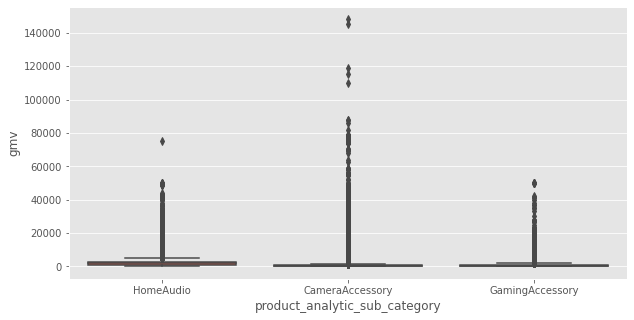

In [295]:
# check for outliers in GMV
plt.figure(figsize=(10,5))
sns.boxplot(y='gmv', x='product_analytic_sub_category', data= consumer_df)

Camera accessories got huge amount of outliers

In [296]:
consumer_df.loc[(consumer_df['product_analytic_sub_category'] == 'HomeAudio')]['gmv'].describe()

count    111134.000000
mean       2147.012503
std        1985.995794
min         129.000000
25%        1019.000000
50%        1900.000000
75%        2599.000000
max       75000.000000
Name: gmv, dtype: float64

In [297]:
consumer_df.loc[(consumer_df['product_analytic_sub_category'] == 'HomeAudio')]['gmv'].quantile(0.95)

4690.0

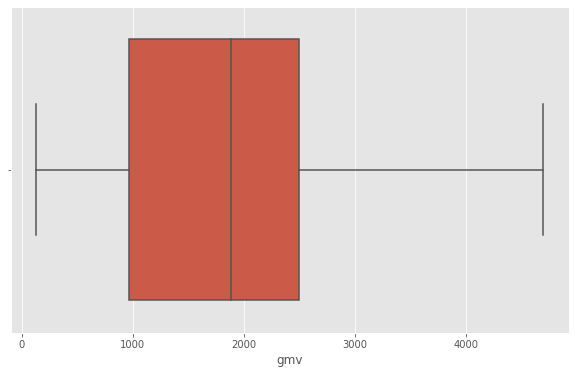

In [298]:
# Check for outliers after capping gmv to 95 percentile for home audio
sns.boxplot(consumer_df.loc[(consumer_df.product_analytic_sub_category == 'HomeAudio') & (consumer_df.gmv<4700)]['gmv'])

In [299]:
consumer_df.loc[(consumer_df['product_analytic_sub_category'] == 'CameraAccessory')]['gmv'].describe()

count    216003.000000
mean       1172.434950
std        3071.711383
min           0.000000
25%         249.000000
50%         388.000000
75%         829.000000
max      148050.000000
Name: gmv, dtype: float64

In [300]:
# checking 95 percentile GMV for camera percentile
consumer_df.loc[(consumer_df['product_analytic_sub_category'] == 'CameraAccessory')]['gmv'].quantile(0.95)

5990.0

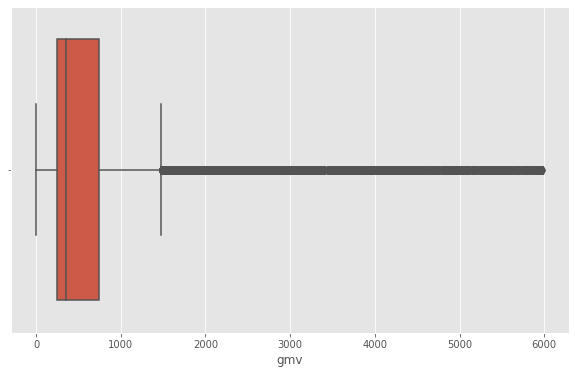

In [301]:
# Capping it to 95 percentile and checking for outliers
sns.boxplot(consumer_df.loc[(consumer_df['product_analytic_sub_category'] == 'CameraAccessory') &
                            (consumer_df.gmv < 5990)]['gmv'])

In [302]:
consumer_df.loc[(consumer_df['product_analytic_sub_category'] == 'GamingAccessory')]['gmv'].describe()

count    185975.000000
mean        844.070368
std        1222.603885
min           0.000000
25%         284.000000
50%         449.000000
75%         945.000000
max       49999.000000
Name: gmv, dtype: float64

In [303]:
consumer_df.loc[(consumer_df['product_analytic_sub_category'] == 'GamingAccessory')]['gmv'].quantile(0.95)

2896.0

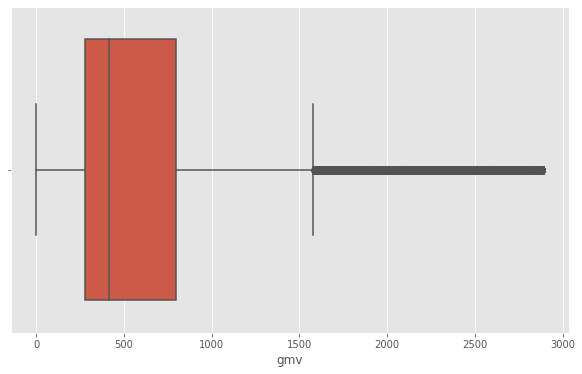

In [304]:
sns.boxplot(consumer_df.loc[(consumer_df['product_analytic_sub_category']=='GamingAccessory') &
                            (consumer_df['gmv']<2896)]['gmv'])

After capping gmv at 95 percentile we see there are still some outlier but if we remove further data then volume will be lost hence not reducing further

In [305]:
# removing outlier based on our analysis
camera_data = consumer_df.loc[(consumer_df['product_analytic_sub_category'] == 'CameraAccessory') &
                              (consumer_df['gmv']< 6000)]
game_data = consumer_df.loc[(consumer_df['product_analytic_sub_category'] == 'GamingAccessory') &
                              (consumer_df['gmv']< 3000)]
audio_data = consumer_df.loc[(consumer_df['product_analytic_sub_category']== 'HomeAudio') &
                               (consumer_df['gmv']<4700)]

In [306]:
# combining all the data
consumer_df_data = pd.concat([camera_data, game_data, audio_data], axis=0)

In [307]:
consumer_df_data.shape

(488110, 21)

## Exploratory Analysis

Transactions per category

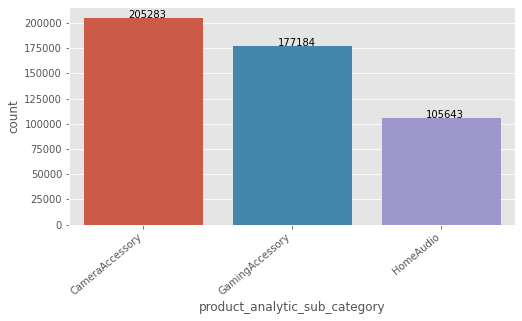

In [308]:
plt.figure(figsize=(8,4))
ax = sns.countplot(consumer_df_data['product_analytic_sub_category'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha="right")

for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()),(p.get_x()+0.3, p.get_height()+50))

CameraAccessory got the maximum transactions followed by GamingAccessory and HomeAudio

Total GMV by category

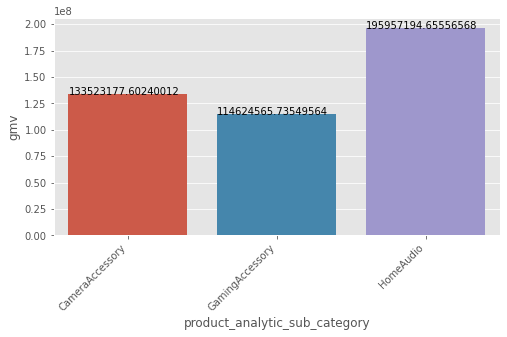

In [309]:
plot_gmv = consumer_df_data.groupby('product_analytic_sub_category')['gmv'].sum().reset_index()
plt.figure(figsize=(8,4))
ax = sns.barplot(x='product_analytic_sub_category', y='gmv' ,data= plot_gmv)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()),(p.get_x(), p.get_height()))

<font color = 'blue'>Maximum revenue is from home audio followed by camera accessories and then game accessory

In [310]:
# Renaming the columns
consumer_df_data = consumer_df_data.rename(columns={'s1_fact.order_payment_type': 'payment_type'})

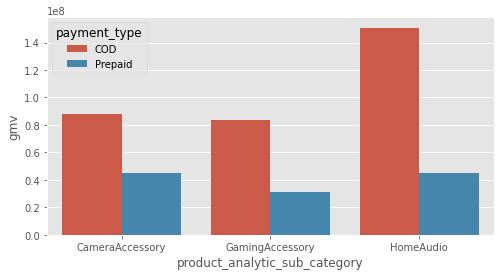

In [311]:
gmv_by_payment_type = consumer_df_data.groupby(['product_analytic_sub_category','payment_type'])['gmv'].sum().reset_index()

plt.figure(figsize=(8,4))
sns.barplot(x='product_analytic_sub_category', y='gmv',hue='payment_type', data= gmv_by_payment_type)

<font color= 'blue'>
    - For COD maximum revenue comes from home audio followed by camera accessory and then gaming accessory <br>
    - For prepaid payment type maximum revenue comes from Camera accessory followed by home audio and then finally gaming accessory

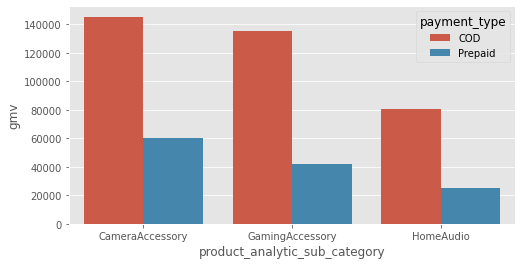

In [312]:
transactions_by_payment_type = consumer_df_data.groupby(['product_analytic_sub_category','payment_type'])['gmv'].count().reset_index()
transactions_by_payment_type = transactions_by_payment_type.rename(columns={'gvm': 'transaction_count'})

plt.figure(figsize=(8,4))
sns.barplot(x='product_analytic_sub_category', y='gmv',hue='payment_type', data= transactions_by_payment_type)

<font color= 'blue'>
    - For COD maximum transactions come from camera accessory followed by gaming accessory and then home audio <br>
    - For prepaid payment type maximum transactions come from Camera accessory followed by gaming accessory and finally home audio

- Check correlation

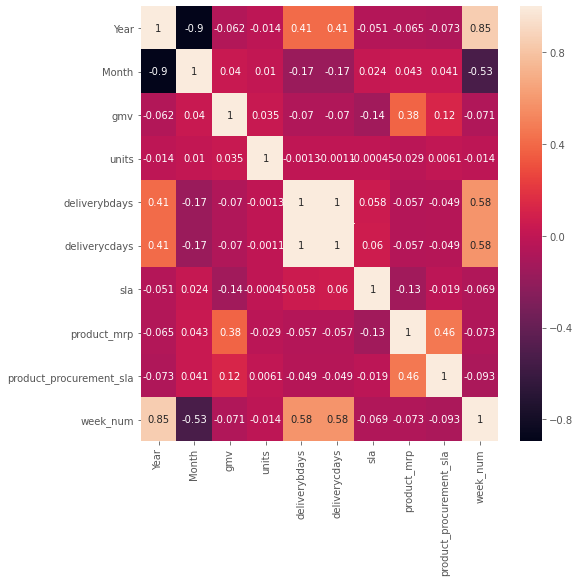

In [313]:
plt.figure(figsize=(8,8))
sns.heatmap(consumer_df_data.corr(), annot= True)

- Positively correlated variables:
    1. year has positive correlation of 0.41 with deliverybdays and deliverycdays
    2. product_mrp got positive correltion on 0.46 with product_procurement_sla
    3. product_mrp with gmv a positive correlation of 0.38 
    <p> 

</p>

- Negatively correlated varibles:
    1. Year and month -ve correlation of 0.9

In [314]:
# Creating dfs for each category
gaming_df = consumer_df[(consumer_df['product_analytic_sub_category']=='GamingAccessory')].drop('product_analytic_sub_category', axis= 1)

camera_df = consumer_df[(consumer_df['product_analytic_sub_category']=='CameraAccessory')].drop('product_analytic_sub_category', axis= 1)

home_df = consumer_df[(consumer_df['product_analytic_sub_category']=='HomeAudio')].drop('product_analytic_sub_category', axis= 1)

## Feature Engineering

In [315]:
# Function to create dataframe from dictionary will be used to create dataframe for holidays, sale days

def createCustomDataframe(listOfValues, columnName):
    df = pd.DataFrame(listOfValues)
    df[columnName] = pd.to_datetime(df[columnName]).dt.date
    df['total_'+columnName] = 1
    df['week_num'] = pd.to_datetime(df[columnName]).dt.week
    df['year'] = pd.to_datetime(df[columnName]).dt.year
    df['week_num'] = df.apply(lambda x: continousweek(x['week_num'],x['year']),axis=1 )
    df = df.groupby('week_num').sum()
    df['is_'+columnName] = 1
    df.drop('year',axis=1, inplace= True)
    return df

In [316]:
#  Taking the special sale days from the data provided
special_sale_days = {'special_sale_day':["2015-07-18","2015-07-19","2015-08-15",
                  "2015-08-16","2015-08-17","2015-08-28",
                  "2015-08-29","2015-08-30","2015-10-15",
                  "2015-10-16","2015-10-17","2015-11-07","2015-11-08","2015-11-09","2015-11-10",
                  "2015-10-11","2015-10-12","2015-11-13","2015-11-14","2015-12-25","2015-12-26",
                  "2015-12-27","2015-12-28","2015-12-29","2015-12-30","2016-01-01","2016-01-02",
                  "2016-01-03","2016-01-20","2016-01-21","2016-01-22","2016-02-01","2016-02-02",
                  "2016-02-20","2016-02-21","2016-02-14","2016-02-15","2016-03-07","2016-03-08",
                  "2016-03-09","2016-05-25","2016-05-26","2016-05-27"]}

In [317]:
special_sale_df = createCustomDataframe(special_sale_days,'special_sale_day')

In [318]:
special_sale_df.shape

(16, 2)

In [319]:
special_sale_df.head()

,total_special_sale_day,is_special_sale_day
week_num,,
29,2,1
33,2,1
34,1,1
35,3,1
41,1,1


#### Create KPIs

In [320]:
def createKPIs(df):
    # KPI 1 : Payment mode indicator
    df['payment_mode_indicator'] = df['s1_fact.order_payment_type'].apply(lambda x: 0 if x == 'COD' else 1)
    
    # KPI 2 : Selling price of each unit
    df['selling_price'] = df['gmv']/df['units']
    
    # KPI 3 : DIscount offered on products
    df['discount'] = np.round((df['product_mrp'] - df['selling_price'])/df['product_mrp'],2)
    
    # KPI 4 : Percent of prepaid orders
    weekly_aggregated_data = df
    weekly_aggregated_data['order_count'] = 1
    weekly_aggregated_data = weekly_aggregated_data.groupby('week_num').sum()
    weekly_aggregated_data['percentage_prepaid_transactions'] = np.round((weekly_aggregated_data.payment_mode_indicator/weekly_aggregated_data.order_count)*100,2)
    weekly_aggregated_data = weekly_aggregated_data.reset_index()[['week_num','percentage_prepaid_transactions']]
    df = pd.merge(df, weekly_aggregated_data, how = 'inner', on = 'week_num')
    return df

In [321]:
# Creating KPI at the weekly level
def weeklyKPI():
    
    # KPI 5 : Holidays
    holidays = {'holiday':["2016-01-01", "2016-02-16", "2016-02-14", "2016-03-17", "2016-04-03", "2016-04-06", 
            "2016-05-10", "2016-05-18", "2016-06-21", "2016-06-24", "2015-07-01", "2015-08-03", 
            "2015-09-07", "2015-10-12", "2015-10-31", "2015-11-11", "2015-12-25", "2015-12-26"] }
    holiday_df = createCustomDataframe(holidays,'holiday')
    
    # KPI 6 : Special sale Days
    special_sale_days = {'special_sale_day':["2015-07-18","2015-07-19","2015-08-15",
                  "2015-08-16","2015-08-17","2015-08-28",
                  "2015-08-29","2015-08-30","2015-10-15",
                  "2015-10-16","2015-10-17","2015-11-07","2015-11-08","2015-11-09","2015-11-10",
                  "2015-10-11","2015-10-12","2015-11-13","2015-11-14","2015-12-25","2015-12-26",
                  "2015-12-27","2015-12-28","2015-12-29","2015-12-30","2016-01-01","2016-01-02",
                  "2016-01-03","2016-01-20","2016-01-21","2016-01-22","2016-02-01","2016-02-02",
                  "2016-02-20","2016-02-21","2016-02-14","2016-02-15","2016-03-07","2016-03-08",
                  "2016-03-09","2016-05-25","2016-05-26","2016-05-27"]}
    special_sale_day_df = createCustomDataframe(special_sale_days,'special_sale_day')
    
    # KPI 7 : Pay Day 
    pay_days = {'pay_days':["2015-07-01","2015-07-15","2015-08-01","2015-08-15",
                "2015-09-01","2015-09-15","2015-10-01","2015-10-15","2015-11-01",
                "2015-11-15","2015-12-01","2015-12-15","2016-01-01","2016-01-15",
                "2016-02-01","2016-02-15","2016-03-01","2016-03-15","2016-04-01",
                "2016-04-15","2016-05-01","2016-05-15","2016-06-01","2016-06-15"]}
    pay_days_df = createCustomDataframe(pay_days,'pay_days')
    
    final_df = pd.concat([holiday_df, special_sale_day_df, pay_days_df],axis = 1)
    return final_df.fillna(0).astype('int')
    
    

In [322]:
weeklyKPI().shape

(38, 6)

In [323]:
weeklyKPI().head()

,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days
week_num,,,,,,
27,1,1,0,0,1,1
29,0,0,2,1,1,1
31,0,0,0,0,1,1
32,1,1,0,0,0,0
33,0,0,2,1,1,1


In [324]:
# Adding KPIs to the individual dataframes
game_df_with_KPI = createKPIs(gaming_df)
camera_df_with_KPI = createKPIs(camera_df)
home_df_with_KPI = createKPIs(home_df)

In [325]:
game_df_with_KPI.shape

(185975, 25)

In [326]:
game_df_with_KPI.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_vertical,product_mrp,product_procurement_sla,week_num,payment_mode_indicator,selling_price,discount,order_count,percentage_prepaid_transactions
0,ACCE5FQXQNRRGYNJ,2015-07-01 03:35:02,2015,7,165165918,209727476,385.0,1,0.0,0.0,Prepaid,10,-6.36522665316929E+018,-5.59395622831527E+018,CE,GamingHardware,GamingMouse,699.0,4,27,1,385.0,0.45,1,50.0
1,ACCDZUBWYAPHJCNB,2015-07-01 08:19:18,2015,7,165181041,209744697,1999.0,1,0.0,0.0,Prepaid,1,-1.63331351145461E+018,-5.96455007933364E+018,CE,GamingHardware,GamePad,7999.0,3,27,1,1999.0,0.75,1,50.0
2,ACCDHHF4FKFMYS7Z,2015-07-01 09:06:16,2015,7,165188299,209753076,428.0,1,0.0,0.0,Prepaid,7,-4.96553360481757E+018,5.00574768294722E+018,CE,GamingHardware,GamePad,999.0,3,27,1,428.0,0.57,1,50.0
3,ACCDH7MFZJGRWJCW,2015-07-03 04:16:02,2015,7,165996797,210690495,269.0,1,0.0,0.0,Prepaid,5,-4.32906078546609E+018,6.92947984210176E+018,CE,GamingHardware,GamePad,410.0,1,27,1,269.0,0.34,1,50.0
4,ACCDYFXZ6QEUZEFZ,2015-07-03 08:13:03,2015,7,166010926,210706668,1485.0,1,1.0,1.0,Prepaid,1,-1.17917517326527E+018,-6.08233565509327E+018,CE,GamingHardware,GamePad,1995.0,4,27,1,1485.0,0.26,1,50.0


#### Creating KPI for payment Type

For Gaming Accessories

In [329]:
cod_cnt = game_df_with_KPI.loc[game_df_with_KPI['s1_fact.order_payment_type'] == "COD"]\
.groupby('week_num')['s1_fact.order_payment_type'].count().reset_index().rename(columns={'s1_fact.order_payment_type':'COD_count'})

prepaid_cnt = game_df_with_KPI.loc[game_df_with_KPI['s1_fact.order_payment_type'] == "Prepaid"]\
.groupby('week_num')['s1_fact.order_payment_type'].count().reset_index().rename(columns={'s1_fact.order_payment_type':'Prepaid_count'})

In [330]:
online_orders_GA = pd.merge(cod_cnt,prepaid_cnt,on = "week_num", how = "outer").fillna(0)
online_orders_GA["pct_online_transactions"] = (online_orders_GA["Prepaid_count"]/(online_orders_GA["Prepaid_count"]+online_orders_GA["COD_count"])).round(2)

For Camera Accessories

In [331]:
# Creating KPIs for Prepaid Count, COD Count & Percent Online Orders for Camera
cod_cnt = camera_df_with_KPI.loc[camera_df_with_KPI['s1_fact.order_payment_type'] == "COD"].groupby('week_num')['s1_fact.order_payment_type'].count().reset_index().rename(columns={'s1_fact.order_payment_type':'COD_count'})
prepaid_cnt = camera_df_with_KPI.loc[camera_df_with_KPI['s1_fact.order_payment_type'] == "Prepaid"].groupby('week_num')['s1_fact.order_payment_type'].count().reset_index().rename(columns={'s1_fact.order_payment_type':'Prepaid_count'})
online_orders_CA = pd.merge(cod_cnt,prepaid_cnt,on = "week_num", how = "outer").fillna(0)
online_orders_CA["pct_online_transactions"] = (online_orders_CA["Prepaid_count"]/(online_orders_CA["Prepaid_count"]+online_orders_CA["COD_count"])).round(2)

In [332]:
# Creating KPIs for Prepaid Count, COD Count & Percent Online Orders for HomeAudio
cod_cnt = home_df_with_KPI.loc[home_df_with_KPI['s1_fact.order_payment_type'] == "COD"].groupby('week_num')['s1_fact.order_payment_type'].count().reset_index().rename(columns={'s1_fact.order_payment_type':'COD_count'})
prepaid_cnt = home_df_with_KPI.loc[home_df_with_KPI['s1_fact.order_payment_type'] == "Prepaid"].groupby('week_num')['s1_fact.order_payment_type'].count().reset_index().rename(columns={'s1_fact.order_payment_type':'Prepaid_count'})
online_orders_HA = pd.merge(cod_cnt,prepaid_cnt,on = "week_num", how = "outer").fillna(0)
online_orders_HA["pct_online_transactions"] = (online_orders_CA["Prepaid_count"]/(online_orders_CA["Prepaid_count"]+online_orders_CA["COD_count"])).round(2)

In [333]:
# Checking for products under sub-category
product_info_camera = camera_df_with_KPI.groupby(['week_num','product_analytic_vertical'])['units'].sum().reset_index()

In [334]:
product_info_camera.head()

,week_num,product_analytic_vertical,units
0,26,CameraAccessory,1
1,27,Binoculars,6
2,27,CameraAccessory,1
3,27,CameraBag,8
4,27,CameraBattery,12


In [335]:
product_info_camera_KPI = product_info_camera.pivot_table(index='week_num',
                                                         columns='product_analytic_vertical',
                                                         values = 'units',aggfunc= np.sum).fillna("0").reset_index()

cols = product_info_camera_KPI.columns

product_info_camera_KPI[cols] = product_info_camera_KPI[cols].apply(pd.to_numeric, errors='coerce')

In [336]:
# Counting units of each product sold under sub category
product_unit_sold_camera = product_info_camera.groupby('product_analytic_vertical')['units'].sum().reset_index().sort_values(by=['units'],ascending = False)

product_unit_sold_camera.head()

,product_analytic_vertical,units
16,Flash,48401
3,CameraBattery,37959
18,Lens,32669
13,CameraTripod,31646
2,CameraBag,15968


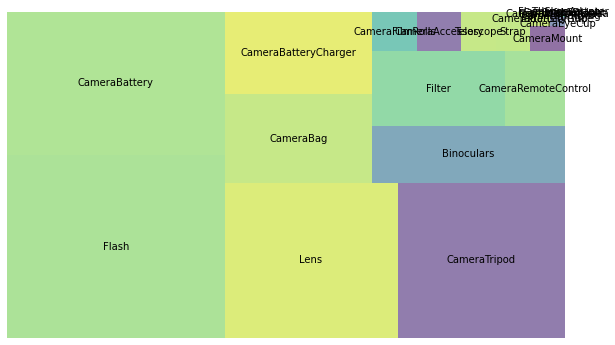

In [337]:
import squarify
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,6)

squarify.plot(sizes =product_unit_sold_camera['units'], label = product_unit_sold_camera['product_analytic_vertical'],
             alpha=.6)
plt.axis('off')
plt.show()

In [338]:
# Checking for products under sub-category
product_info_game = game_df_with_KPI.groupby(['week_num','product_analytic_vertical'])['units'].sum().reset_index()

In [339]:
product_info_game_KPI = product_info_game.pivot_table(index='week_num',
                                                         columns='product_analytic_vertical',
                                                         values = 'units',aggfunc= np.sum).fillna("0").reset_index()

cols = product_info_game_KPI.columns

product_info_game_KPI[cols] = product_info_game_KPI[cols].apply(pd.to_numeric, errors='coerce')

In [340]:
# Counting units of each product sold under sub category
product_unit_sold_game = product_info_game.groupby('product_analytic_vertical')['units'].sum().reset_index().sort_values(by=['units'],ascending = False)

product_unit_sold_game.head()

,product_analytic_vertical,units
6,GamingHeadset,61255
2,GamePad,55245
9,GamingMouse,36686
3,GamingAccessoryKit,8900
14,TVOutCableAccessory,6949


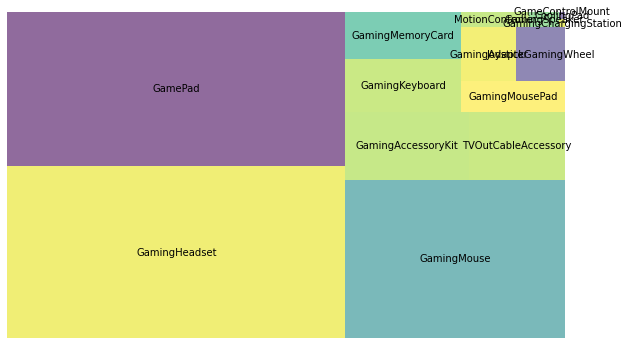

In [341]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,6)

squarify.plot(sizes =product_unit_sold_game['units'], label = product_unit_sold_game['product_analytic_vertical'],
             alpha=.6)
plt.axis('off')
plt.show()

In [342]:
# Checking for products under sub-category
product_info_home = home_df_with_KPI.groupby(['week_num','product_analytic_vertical'])['units'].sum().reset_index()

In [343]:
product_info_home_KPI = product_info_home.pivot_table(index='week_num',
                                                         columns='product_analytic_vertical',
                                                         values = 'units',aggfunc= np.sum).fillna("0").reset_index()

cols = product_info_home_KPI.columns

product_info_home_KPI[cols] = product_info_home_KPI[cols].apply(pd.to_numeric, errors='coerce')

In [344]:
# Counting units of each product sold under sub category
product_unit_sold_home = product_info_home.groupby('product_analytic_vertical')['units'].sum().reset_index().sort_values(by=['units'],ascending = False)

product_unit_sold_home.head()

,product_analytic_vertical,units
6,HomeAudioSpeaker,77162
4,FMRadio,24992
10,VoiceRecorder,3577
0,BoomBox,2481
2,Dock,1911


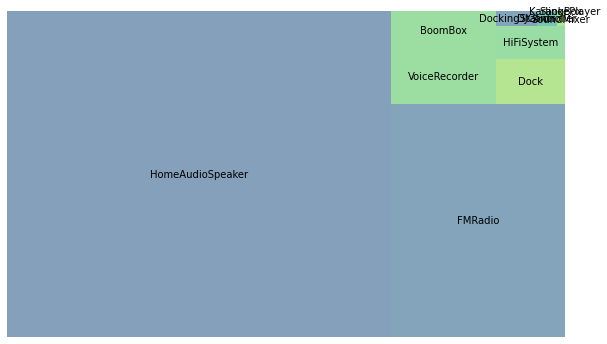

In [345]:
squarify.plot(sizes=product_unit_sold_home['units'], label =product_unit_sold_home['product_analytic_vertical'], alpha = .6)

plt.axis('off')
plt.show()

### Including NPS and Stock index

In [346]:
# Reading NPS_data from media file
# nps_data = pd.read_excel('Media data and other information.xlsx', sheet_name = 'Monthly NPS Score', header= 1).T.reset_index()

nps_data = pd.read_excel("Media data and other information.xlsx", sheet_name = 'Monthly NPS Score', header = 1)
nps_data.columns.values[0]='score'

In [347]:
nps_data.head()

,score,July'15,Aug'15,Sept'15,Oct'15,Nov'15,Dec'15,Jan'16,Feb'16,Mar'16,Apr'16,May'16,June'16
0,NPS,54.599588,59.987101,46.925419,44.398389,47.0,45.8,47.093031,50.327406,49.02055,51.827605,47.306951,50.516687
1,Stock Index,1177.000000,1206.000000,1101.000000,1210.000000,1233.0,1038.0,1052.000000,1222.000000,1015.00000,1242.000000,1228.000000,1194.000000


In [348]:
nps_data.reset_index(drop=True, inplace = True)

In [349]:
nps_data

,score,July'15,Aug'15,Sept'15,Oct'15,Nov'15,Dec'15,Jan'16,Feb'16,Mar'16,Apr'16,May'16,June'16
0,NPS,54.599588,59.987101,46.925419,44.398389,47.0,45.8,47.093031,50.327406,49.02055,51.827605,47.306951,50.516687
1,Stock Index,1177.000000,1206.000000,1101.000000,1210.000000,1233.0,1038.0,1052.000000,1222.000000,1015.00000,1242.000000,1228.000000,1194.000000


In [350]:
nps_dat = nps_data.T

In [351]:
nps_data.reset_index(drop=False,  inplace=True)

In [352]:
nps_data

,index,score,July'15,Aug'15,Sept'15,Oct'15,Nov'15,Dec'15,Jan'16,Feb'16,Mar'16,Apr'16,May'16,June'16
0,0,NPS,54.599588,59.987101,46.925419,44.398389,47.0,45.8,47.093031,50.327406,49.02055,51.827605,47.306951,50.516687
1,1,Stock Index,1177.000000,1206.000000,1101.000000,1210.000000,1233.0,1038.0,1052.000000,1222.000000,1015.00000,1242.000000,1228.000000,1194.000000


In [353]:
nps_data.reset_index(drop=True, inplace=True)

# Transpose the dataframe
nps_data = nps_data.T

# reset index
nps_data.reset_index(drop=False, inplace=True)

# renaming columns
nps_data.columns = ['index', 'NPS', 'Stock Index']
nps_data.drop(nps_data.index[0:2], inplace=True)
nps_data

,index,NPS,Stock Index
2,July'15,54.5996,1177
3,Aug'15,59.9871,1206
4,Sept'15,46.9254,1101
5,Oct'15,44.3984,1210
6,Nov'15,47,1233
7,Dec'15,45.8,1038
8,Jan'16,47.093,1052
9,Feb'16,50.3274,1222
10,Mar'16,49.0206,1015
11,Apr'16,51.8276,1242


In [354]:
#Creating Month & Year columns to merge with transactional data
nps_data['Year'] = nps_data['index'].apply(lambda x: int("20"+x.split("'")[1]))
nps_data['Month'] = nps_data['index'].apply(lambda x: x.split("'")[0][:3])

#Create mapping to convert month names to month number
import calendar

d = dict((v,k) for k,v in enumerate(calendar.month_abbr))
d

nps_data.Month = nps_data.Month.apply(lambda x: d.get(x))

#Drop index column from media_data
nps_data.drop('index', inplace = True, axis = 1)

nps_data

,NPS,Stock Index,Year,Month
2,54.5996,1177,2015,7
3,59.9871,1206,2015,8
4,46.9254,1101,2015,9
5,44.3984,1210,2015,10
6,47,1233,2015,11
7,45.8,1038,2015,12
8,47.093,1052,2016,1
9,50.3274,1222,2016,2
10,49.0206,1015,2016,3
11,51.8276,1242,2016,4


In [355]:
# Adding NPS KPI to each of the dataframes
game_df_with_KPI = pd.merge(nps_data,game_df_with_KPI,on=['Month','Year'],how='inner')
camera_df_with_KPI = pd.merge(nps_data,camera_df_with_KPI,on=['Month','Year'],how='inner')
home_df_with_KPI = pd.merge(nps_data,home_df_with_KPI,on=['Month','Year'],how='inner')

In [356]:
home_df_with_KPI.head()

,NPS,Stock Index,Year,Month,fsn_id,order_date,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_vertical,product_mrp,product_procurement_sla,week_num,payment_mode_indicator,selling_price,discount,order_count,percentage_prepaid_transactions
0,54.5996,1177,2015,7,ACCEFUJRZ5ZCJKYT,2015-07-01 09:02:59,165187825,209752531,2249.0,1,0.0,0.0,Prepaid,7,-8.65906252854915E+018,4.79427064452622E+017,CE,EntertainmentSmall,HomeAudioSpeaker,2800.0,4,27,1,2249.0,0.20,1,71.7
1,54.5996,1177,2015,7,ACCDRKG3H7PJRG4T,2015-07-01 10:15:48,165204036,209771258,3040.0,1,0.0,0.0,Prepaid,0,2.77380264714813E+018,-9.779010321304E+017,CE,EntertainmentSmall,HomeAudioSpeaker,3650.0,5,27,1,3040.0,0.17,1,71.7
2,54.5996,1177,2015,7,BBXE29UFECCU6GWG,2015-07-01 11:43:08,165227580,209798750,2950.0,1,0.0,0.0,Prepaid,6,2.83909688166493E+018,-5.1750058942027E+018,CE,EntertainmentSmall,BoomBox,3299.0,5,27,1,2950.0,0.11,1,71.7
3,54.5996,1177,2015,7,FMRDUWHRJP3FGPNM,2015-07-03 00:05:06,165967508,210657202,1599.0,1,0.0,0.0,Prepaid,7,5.24497785024425E+018,-3.89052446649651E+018,CE,EntertainmentSmall,FMRadio,3700.0,3,27,1,1599.0,0.57,1,71.7
4,54.5996,1177,2015,7,ACCDRKG3H7PJRG4T,2015-07-03 01:33:35,165986063,210678327,2990.0,1,1.0,1.0,Prepaid,1,7.64711674406358E+018,7.68693767541594E+018,CE,EntertainmentSmall,HomeAudioSpeaker,3650.0,5,27,1,2990.0,0.18,1,71.7


#### Weekly aggregation and final df creation

In [115]:
#GamingAccessory Data - Aggregating weekly some features being summed up & for some taking mean
GamingAccessory_data_sum = game_df_with_KPI[['gmv','units','week_num']].groupby('week_num').sum()
GamingAccessory_data_mean = game_df_with_KPI[['sla','product_procurement_sla','week_num',
                                                            'product_mrp','selling_price','discount','NPS']].groupby('week_num').mean()
GamingAccessory_data_count = game_df_with_KPI[['order_id','week_num']].groupby('week_num').count().rename(columns={'order_id':'total_transactions'})

final_gaming_data = pd.concat([GamingAccessory_data_sum, GamingAccessory_data_mean,GamingAccessory_data_count], axis = 1).reset_index()

In [357]:
final_gaming_data.head()

,week_num,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,total_transactions,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days
0,27,3.788700e+04,30,2.933333,2.966667,3457.800000,1262.900000,0.275000,30,1.0,1.0,0.0,0.0,1.0,1.0
1,28,2.688958e+06,3032,5.460737,3.213343,1884.486449,898.804031,0.401953,2878,0.0,0.0,0.0,0.0,0.0,0.0
2,29,2.270363e+06,2944,5.335189,2.721232,1827.610987,823.323816,0.426752,2694,0.0,0.0,2.0,1.0,1.0,1.0
3,30,2.588844e+06,2545,5.429508,2.603279,2345.636475,1027.983402,0.370992,2440,0.0,0.0,0.0,0.0,0.0,0.0
4,31,1.900937e+06,1841,5.685535,3.188679,5126.751858,1040.690109,0.428805,1749,0.0,0.0,0.0,0.0,1.0,1.0


In [358]:
#Merging with the weekly aggregate KPIs i.e. total_paydays, total_holidays, is_payday, is_holiday, total_special_days, is_special_day
final_gaming_data = pd.merge(final_gaming_data, weeklyKPI().reset_index(), on = 'week_num', how = 'left').fillna(0)
final_gaming_data.shape

(53, 21)

In [359]:
#Merging with Prepaid/COD KPI
final_gaming_data = pd.merge(final_gaming_data,online_orders_GA,on = "week_num", how = "left")
final_gaming_data.shape

(53, 24)

## Media Investment data

In [118]:
# Reading the media data from the provided file
media_investment = pd.read_excel("Media data and other information.xlsx", sheet_name = 'Media Investment', header = 2)
media_investment

,Unnamed: 0,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,NaN,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,NaN,NaN
1,NaN,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,NaN,NaN
2,NaN,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,NaN,NaN
3,NaN,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,NaN,NaN
4,NaN,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,NaN,NaN
5,NaN,2015.0,12.0,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,NaN,NaN
6,NaN,2016.0,1.0,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000
7,NaN,2016.0,2.0,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,NaN,NaN
8,NaN,2016.0,3.0,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545
9,NaN,2016.0,4.0,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,NaN,NaN


In [119]:
media_investment.columns.values[0]='index_2'

In [120]:
#Removing unwanted (last 4 rows)
media_investment = media_investment.iloc[:-4].reset_index()

In [121]:
media_investment.reset_index(drop=True, inplace=True)

In [122]:
media_investment.drop('index_2', axis=1, inplace = True)

In [123]:
media_investment.drop('index', axis=1, inplace= True)

In [124]:
media_investment = media_investment.fillna(0)
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000
1,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000
2,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.00,0.000000
3,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.00,0.000000
4,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.00,0.000000
5,2015.0,12.0,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,0.00,0.000000
6,2016.0,1.0,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000
7,2016.0,2.0,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,0.00,0.000000
8,2016.0,3.0,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545
9,2016.0,4.0,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,0.00,0.000000


In [125]:
# Mapping month and number of weeks
number_of_weeks = {'Month':[1,2,3,4,5,6,7,8,9,10,11,12], 'number_of_weeks':[4,4,5,4,4,5,4,4,5,4,4,5]}
number_of_weeks_df = pd.DataFrame(number_of_weeks)
number_of_weeks_df

,Month,number_of_weeks
0,1,4
1,2,4
2,3,5
3,4,4
4,5,4
5,6,5
6,7,4
7,8,4
8,9,5
9,10,4


In [126]:
media_investment = pd.merge(media_investment,number_of_weeks_df, on = 'Month', how = 'inner')
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other,number_of_weeks
0,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000,4
1,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000,4
2,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.00,0.000000,5
3,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.00,0.000000,4
4,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.00,0.000000,4
5,2015.0,12.0,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,0.00,0.000000,5
6,2016.0,1.0,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000,4
7,2016.0,2.0,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,0.00,0.000000,4
8,2016.0,3.0,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545,5
9,2016.0,4.0,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,0.00,0.000000,4


In [127]:
# Calculating weekly insights for media spend
media_investment['TV']  = media_investment['TV']/media_investment['number_of_weeks']
media_investment['Digital']  = media_investment['Digital']/media_investment['number_of_weeks']
media_investment['Sponsorship']  = media_investment['Sponsorship']/media_investment['number_of_weeks']
media_investment['Content Marketing']  = media_investment['Content Marketing']/media_investment['number_of_weeks']
media_investment['Online marketing']  = media_investment['Online marketing']/media_investment['number_of_weeks']
media_investment[' Affiliates']  = media_investment[' Affiliates']/media_investment['number_of_weeks']
media_investment['SEM']  = media_investment['SEM']/media_investment['number_of_weeks']
media_investment['Radio']  = media_investment['Radio']/media_investment['number_of_weeks']
media_investment['Other']  = media_investment['Other']/media_investment['number_of_weeks']

In [128]:
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other,number_of_weeks
0,2015.0,7.0,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.000,0.000000,4
1,2015.0,8.0,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,0.628382,0.000,0.000000,4
2,2015.0,9.0,96.254380,0.775901,0.271306,12.557530,0.122058,3.275998,1.007653,1.240430,0.000,0.000000,5
3,2015.0,10.0,170.156297,1.536178,3.155620,21.168133,0.861019,6.092944,1.743428,7.981753,0.000,0.000000,4
4,2015.0,11.0,51.216220,1.055157,0.318867,3.543029,0.042158,4.890394,1.648942,1.305508,0.000,0.000000,4
5,2015.0,12.0,106.745312,1.079500,0.612672,11.341084,0.213461,4.500751,1.365388,2.236206,0.000,0.000000,5
6,2016.0,1.0,74.196000,1.095000,0.114000,1.050000,0.225000,5.725000,1.842500,1.050000,0.675,6.772500,4
7,2016.0,2.0,48.052000,0.646502,0.478163,2.931389,0.149193,4.973092,1.616255,1.218407,0.000,0.000000,4
8,2016.0,3.0,100.024621,1.860000,0.420000,8.318000,0.074000,3.687564,1.243533,1.038718,0.174,3.189109,5
9,2016.0,4.0,56.848241,1.301299,0.217973,6.077088,0.008719,4.128627,1.423364,1.054990,0.000,0.000000,4


In [129]:
# Generating unique week number, month and year
order_week_data = consumer_df[['week_num',"Month","Year"]].drop_duplicates(keep = 'first', subset= None)\
.reset_index().drop('index', axis=1).sort_values(by = 'week_num')

order_week_data

,week_num,Month,Year
0,21,5,2015
1,26,6,2015
2,27,7,2015
66,27,7,2016
67,28,7,2016
3,28,7,2015
4,29,7,2015
5,30,7,2015
6,31,7,2015
7,31,8,2015


In [130]:
order_week_data = order_week_data.sort_values(by = ['week_num','Month']).drop_duplicates(keep = 'last', subset = 'week_num')

In [131]:
order_week_data

,week_num,Month,Year
0,21,5,2015
1,26,6,2015
66,27,7,2016
3,28,7,2015
4,29,7,2015
5,30,7,2015
7,31,8,2015
8,32,8,2015
9,33,8,2015
10,34,8,2015


In [132]:
order_week_data.shape

(55, 3)

In [133]:
#merging the order_week with media data to get media spent weekwise
media_investment_weekwise = pd.merge(order_week_data, media_investment, on = ["Month","Year"], how = "inner").drop('number_of_weeks', axis =1)
media_investment_weekwise.head()

,week_num,Month,Year,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,28,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,29,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
2,30,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
3,31,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,0.628382,0.0,0.0
4,32,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,0.628382,0.0,0.0


Analyze media spent on different channel by week

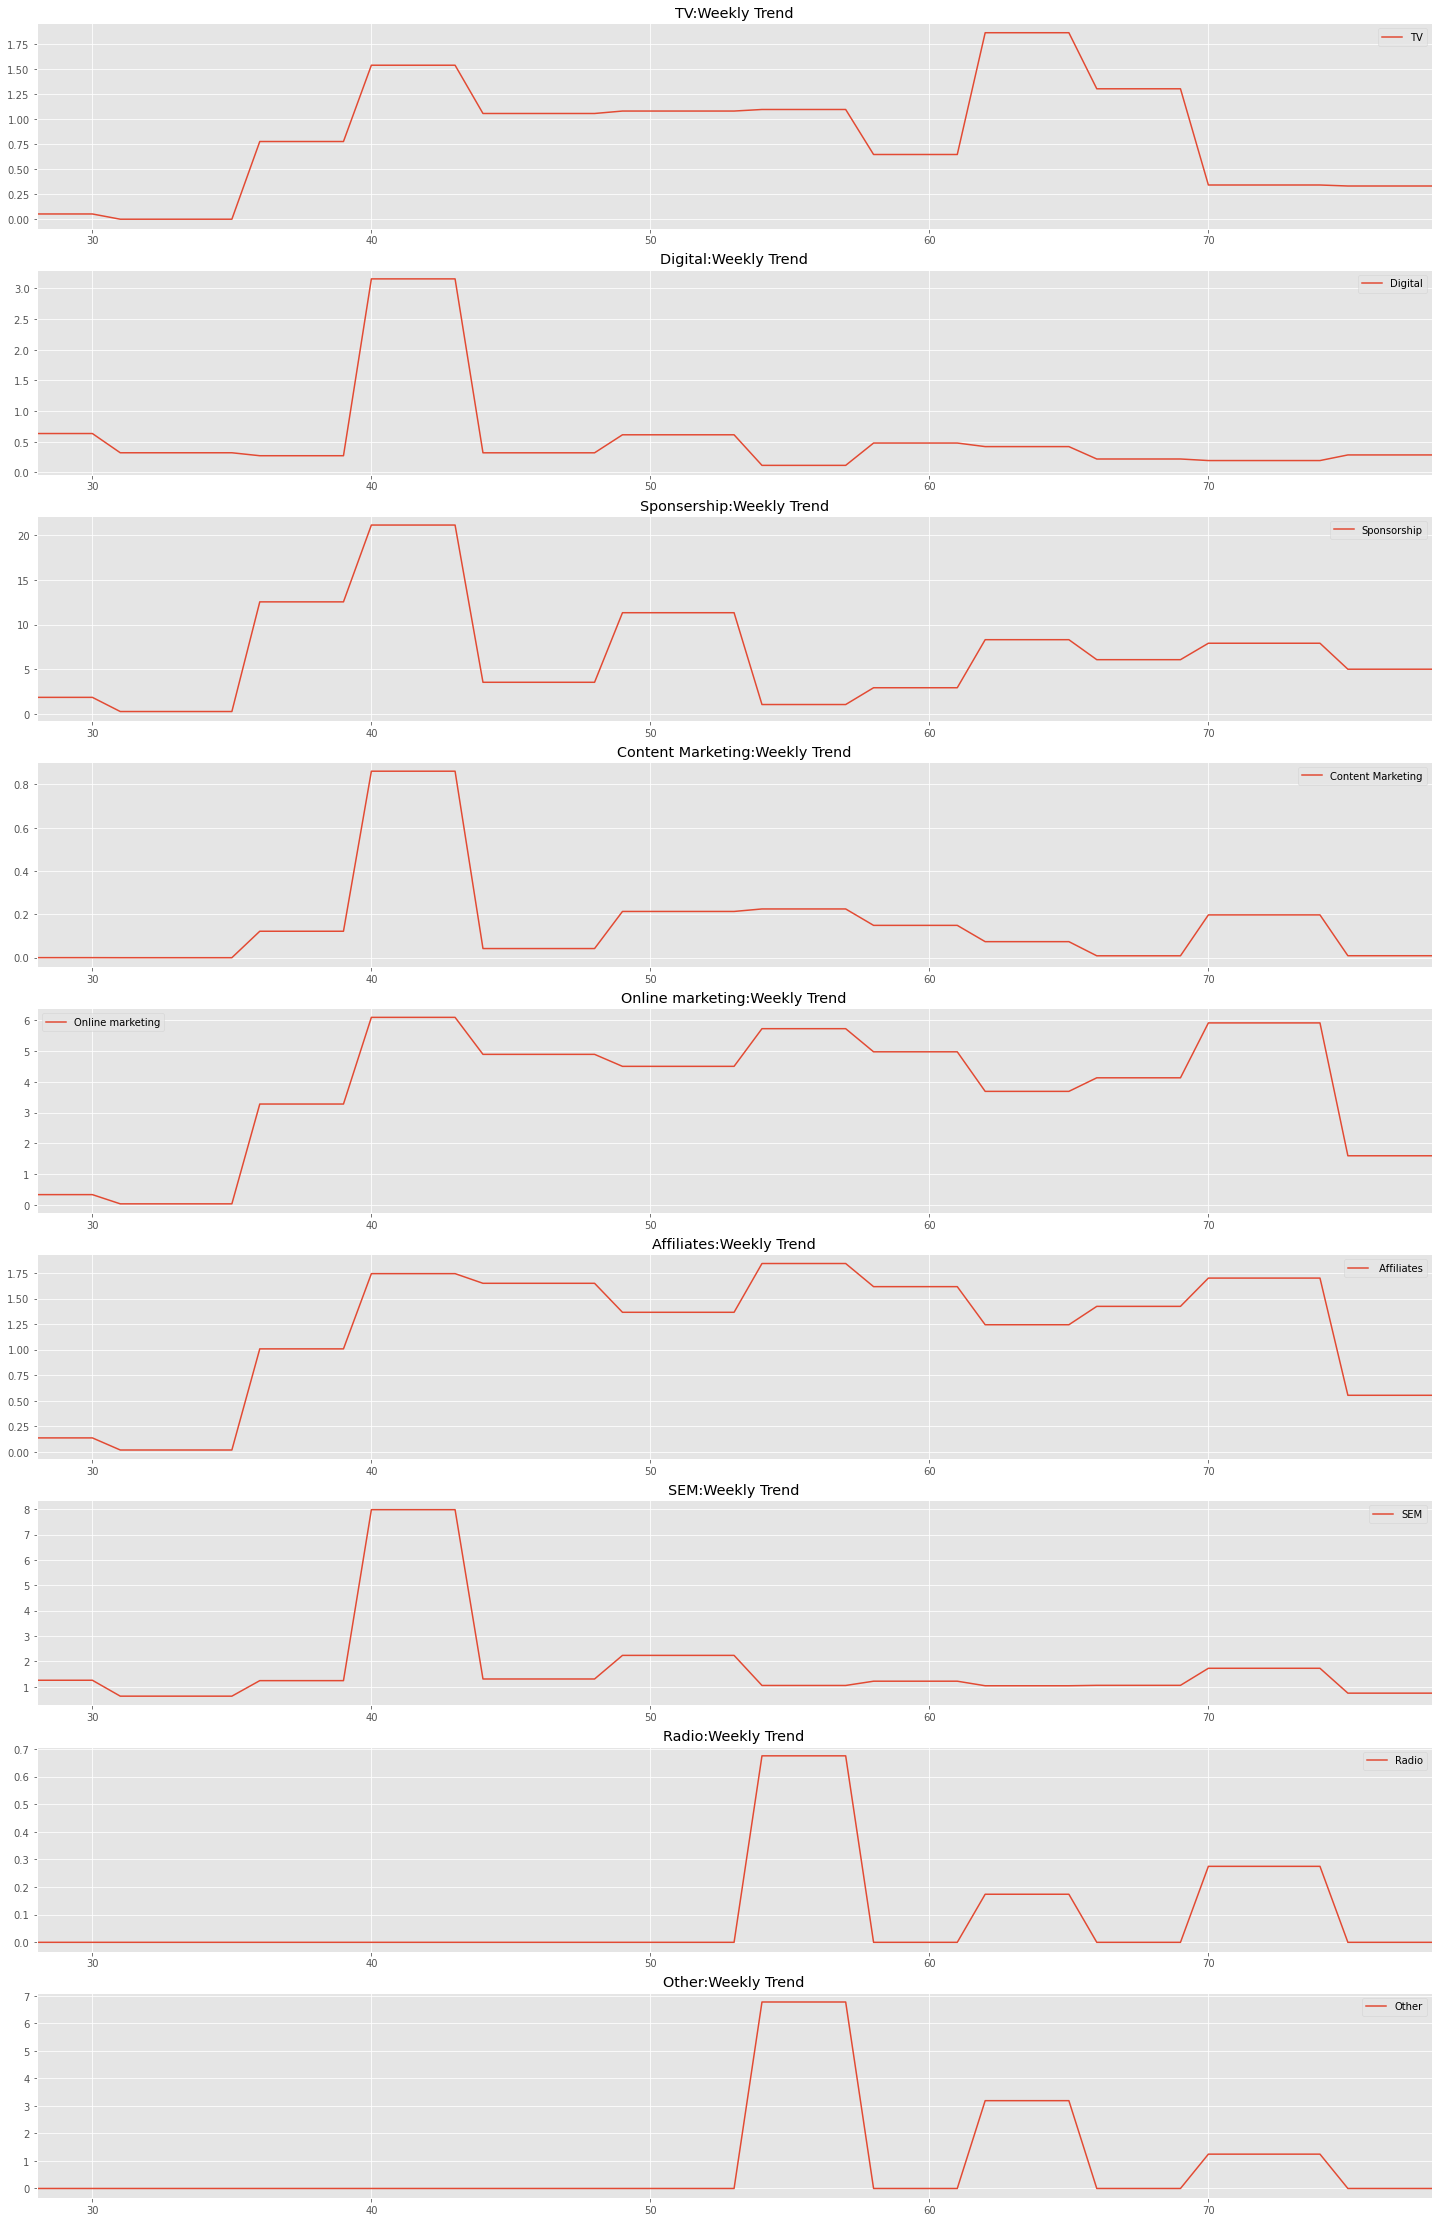

In [134]:
fig = plt.figure(figsize=(25,40))

ax1 = fig.add_subplot(911)
ax1.set_title('TV:Weekly Trend')
ax1.xaxis.label.set_visible(False)

ax2 = fig.add_subplot(912)
ax2.set_title('Digital:Weekly Trend')
ax2.xaxis.label.set_visible(False)

ax3= fig.add_subplot(913)
ax3.set_title('Sponsership:Weekly Trend')
ax3.xaxis.label.set_visible(False)

ax4= fig.add_subplot(914)
ax4.set_title('Content Marketing:Weekly Trend')
ax4.xaxis.label.set_visible(False)

ax5= fig.add_subplot(915)
ax5.set_title('Online marketing:Weekly Trend')
ax5.xaxis.label.set_visible(False)

ax6= fig.add_subplot(916)
ax6.set_title('Affiliates:Weekly Trend')
ax6.xaxis.label.set_visible(False)

ax7= fig.add_subplot(917)
ax7.set_title('SEM:Weekly Trend')
ax7.xaxis.label.set_visible(False)

ax8= fig.add_subplot(918)
ax8.set_title('Radio:Weekly Trend')
ax8.xaxis.label.set_visible(False)

ax9= fig.add_subplot(919)
ax9.set_title('Other:Weekly Trend')
ax9.xaxis.label.set_visible(False)

# For plots
media_investment_weekwise.plot(x='week_num', y=['TV'], ax=ax1)
media_investment_weekwise.plot(x='week_num', y=['Digital'], ax=ax2)
media_investment_weekwise.plot(x='week_num', y=['Sponsorship'], ax=ax3)
media_investment_weekwise.plot(x='week_num', y=['Content Marketing'], ax=ax4)
media_investment_weekwise.plot(x='week_num', y=['Online marketing'], ax=ax5)
media_investment_weekwise.plot(x='week_num', y=[' Affiliates'], ax=ax6)
media_investment_weekwise.plot(x='week_num', y=['SEM'], ax=ax7)
media_investment_weekwise.plot(x='week_num', y=['Radio'], ax=ax8)
media_investment_weekwise.plot(x='week_num', y=['Other'], ax=ax9)

<font color='blue'>
    Maximum media spending happened between week 39 to 45 for most of the channels.<br>
    Maximum spending was done through Sponsership channel 

In [135]:
len(media_investment_weekwise) == len(order_week_data)

False

In [136]:
media_investment_weekwise.shape

(51, 13)

In [137]:
order_week_data.shape

(55, 3)

In [138]:
# Function to create adstock values based on adstock rate passed to it
def getAdStockValues(media_investment_df, col_name, adstock_rate):
    media_investment_df['week_carry_over_1_value'] = adstock_rate**1 * media_investment_df[col_name]
    media_investment_df['week_carry_over_2_value'] = adstock_rate**2 * media_investment_df[col_name]
    media_investment_df['week_carry_over_3_value'] = adstock_rate**2 * media_investment_df[col_name]
    media_investment_df['week_carry_over_4_value'] = adstock_rate**2 * media_investment_df[col_name]
    media_investment_df['week_carry_over_5_value'] = adstock_rate**2 * media_investment_df[col_name]
    
    for i in range(0, len(media_investment_df)):
        week1CarryOverValue  = media_investment_df.loc[i-1,["week_carry_over_1_value"]][0] if(i-1 > -1) else 0
        week2CarryOverValue  = media_investment_df.loc[i-2,["week_carry_over_2_value"]][0] if(i-2 > -1) else 0
        week3CarryOverValue  = media_investment_df.loc[i-3,["week_carry_over_3_value"]][0] if(i-3 > -1) else 0
        week4CarryOverValue  = media_investment_df.loc[i-4,["week_carry_over_4_value"]][0] if(i-4 > -1) else 0
        week5CarryOverValue  = media_investment_df.loc[i-5,["week_carry_over_5_value"]][0] if(i-5 > -1) else 0
        media_investment_df.loc[i,"adStock_"+col_name] = media_investment_df.loc[i,[col_name]][0] + week1CarryOverValue + week2CarryOverValue + week3CarryOverValue + week4CarryOverValue + week5CarryOverValue
    return media_investment_df[["week_num","adStock_"+col_name]]

In [139]:
adStock_TV = getAdStockValues(media_investment_weekwise[['TV','week_num']],"TV", 0.5)[["adStock_TV"]]
adStock_digital = getAdStockValues(media_investment_weekwise[['Digital','week_num']],"Digital", 0.5)[["adStock_Digital"]]
adStock_sponsorship = getAdStockValues(media_investment_weekwise[['Sponsorship','week_num']],"Sponsorship", 0.5)[["adStock_Sponsorship"]]
adStock_content_marketing = getAdStockValues(media_investment_weekwise[['Content Marketing','week_num']],"Content Marketing", 0.5)[["adStock_Content Marketing"]]
adStock_online_marketing = getAdStockValues(media_investment_weekwise[['Online marketing','week_num']],"Online marketing", 0.5)[["adStock_Online marketing"]]
adStock_affiliates = getAdStockValues(media_investment_weekwise[[' Affiliates','week_num']]," Affiliates", 0.5)[["adStock_ Affiliates"]]
adStock_SEM = getAdStockValues(media_investment_weekwise[['SEM','week_num']],"SEM", 0.5)[["adStock_SEM"]]
adStock_radio = getAdStockValues(media_investment_weekwise[['Radio','week_num']],"Radio", 0.5)[["adStock_Radio"]]
adStock_other = getAdStockValues(media_investment_weekwise[['Other','week_num']],"Other", 0.5)

In [140]:
# Concating all the adstock_values into final df
all_adstock = pd.concat([adStock_TV,adStock_digital,adStock_sponsorship, adStock_content_marketing, adStock_online_marketing,
                         adStock_affiliates, adStock_SEM, adStock_radio, adStock_other], axis = 1)

In [141]:
# Merging the adstock data with the media investment data
final_adstock_data = pd.merge(media_investment_weekwise,all_adstock, on = "week_num", how = 'inner')

In [142]:
final_adstock_data.head()

,week_num,Month,Year,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other
0,28,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,29,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0
2,30,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0
3,31,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,0.628382,0.0,0.0,0.055442,0.952772,2.119400,0.000235,0.364130,0.155234,1.884306,0.0,0.0
4,32,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,0.628382,0.0,0.0,0.042789,0.954218,1.788925,0.000177,0.297331,0.130242,1.884516,0.0,0.0


In [143]:
#Let's drop the redundant columns whose information has already been captured from the final_adstock_datafram
final_adstock_data.drop(['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing',
                         'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other'],inplace = True, axis = 1)

In [144]:
final_adstock_data.head()

,week_num,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other
0,28,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,29,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0
2,30,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0
3,31,8,2015,0.055442,0.952772,2.119400,0.000235,0.364130,0.155234,1.884306,0.0,0.0
4,32,8,2015,0.042789,0.954218,1.788925,0.000177,0.297331,0.130242,1.884516,0.0,0.0


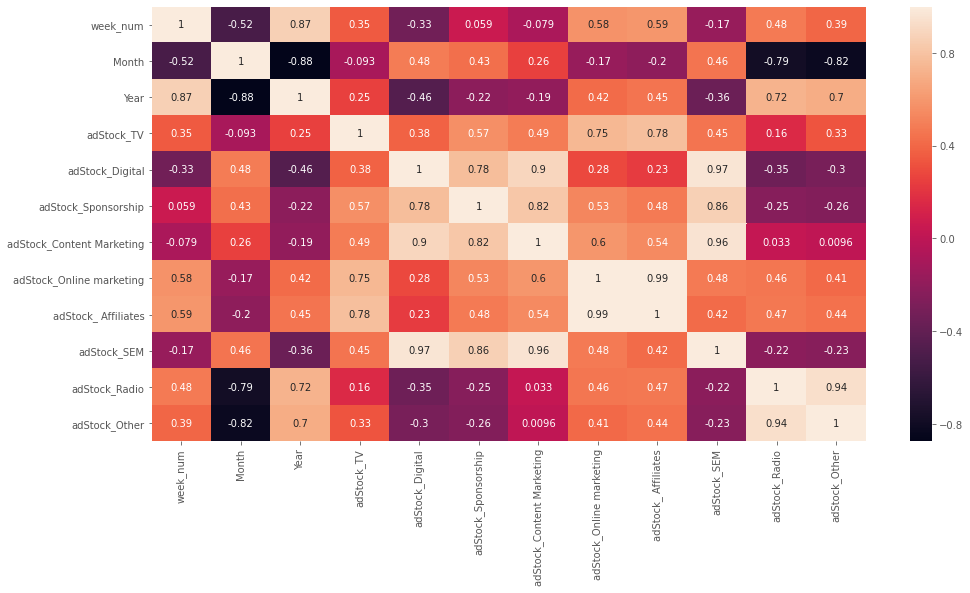

In [145]:
# Visualize the correlation
plt.figure(figsize=(16,8))
sns.heatmap(final_adstock_data.corr(), annot = True)

<font color='blue'>
Strong Correlation between : <br>
    - order_week & month, year & month, order_week & year <br>
    - adStock_Affiliates & adStock_Online marketing <br>
    - adStock_Other & adStock_Radio <br>
    - adStock_Digital & adStock_SEM <br>
    - adStock_Content Marketing & adStock_SEM <br>
    - Month & adstock_radio, Month & adstock_others <br>
    - adStock_TV & adStock_affiliates <br>
    - adStock_Sponsorship & adStock_Content Marketing <br>